In [1]:
from toolz.curried import *
from whatever import *
import pandas, requests, ujson
from IPython import display, get_ipython
iframe = partial(display.IFrame, width=800, height=600)


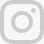

In [2]:
%%html
<blockquote class="instagram-media" data-instgrm-captioned data-instgrm-version="7" style=" background:#FFF; border:0; border-radius:3px; box-shadow:0 0 1px 0 rgba(0,0,0,0.5),0 1px 10px 0 rgba(0,0,0,0.15); margin: 1px; max-width:658px; padding:0; width:99.375%; width:-webkit-calc(100% - 2px); width:calc(100% - 2px);"><div style="padding:8px;"> <div style=" background:#F8F8F8; line-height:0; margin-top:40px; padding:50.0% 0; text-align:center; width:100%;"> <div style=" background:url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACwAAAAsCAMAAAApWqozAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAAMUExURczMzPf399fX1+bm5mzY9AMAAADiSURBVDjLvZXbEsMgCES5/P8/t9FuRVCRmU73JWlzosgSIIZURCjo/ad+EQJJB4Hv8BFt+IDpQoCx1wjOSBFhh2XssxEIYn3ulI/6MNReE07UIWJEv8UEOWDS88LY97kqyTliJKKtuYBbruAyVh5wOHiXmpi5we58Ek028czwyuQdLKPG1Bkb4NnM+VeAnfHqn1k4+GPT6uGQcvu2h2OVuIf/gWUFyy8OWEpdyZSa3aVCqpVoVvzZZ2VTnn2wU8qzVjDDetO90GSy9mVLqtgYSy231MxrY6I2gGqjrTY0L8fxCxfCBbhWrsYYAAAAAElFTkSuQmCC); display:block; height:44px; margin:0 auto -44px; position:relative; top:-22px; width:44px;"></div></div> <p style=" margin:8px 0 0 0; padding:0 4px;"> <a href="https://www.instagram.com/p/BLB2VL7hjxG/" style=" color:#000; font-family:Arial,sans-serif; font-size:14px; font-style:normal; font-weight:normal; line-height:17px; text-decoration:none; word-wrap:break-word;" target="_blank">Notebookism #calligraphy #fabriano</a></p> <p style=" color:#c9c8cd; font-family:Arial,sans-serif; font-size:14px; line-height:17px; margin-bottom:0; margin-top:8px; overflow:hidden; padding:8px 0 7px; text-align:center; text-overflow:ellipsis; white-space:nowrap;">A video posted by Tony Fast (@docfast) on <time style=" font-family:Arial,sans-serif; font-size:14px; line-height:17px;" datetime="2016-10-01T17:35:34+00:00">Oct 1, 2016 at 10:35am PDT</time></p></div></blockquote>
<script async defer src="//platform.instagram.com/en_US/embeds.js"></script>

In [3]:
import ujson
def read_json(fn):
    with open('../../'+fn, 'r') as f:
        data = ujson.load(f)
    return data

# Find all my notebooks
__notebooks = (__x('http://localhost:8888/api/contents')
 | requests.get | _this().json()['content']._
) + __x().get('type').eq('notebook').__ 


In [4]:
# Compose a function to read all of the notebooks
__contents =  __notebooks | pluck('name') | list | map(read_json) | list

# Clean up the notebooks to extract my imports
__notebook_imports = (
    __x(__contents.copy().pluck('cells').first.__()) 
    + _this()['cell_type'].copy().eq('code')._ 
    | pluck('source') 
    | concat 
    | '\n'.join 
    | (lambda x: x.split(';')) 
    | map(lambda x: first(x.split('#',1)))
    | '\n'.join
    | str.splitlines
)

__notebook_imports = __notebook_imports * str.lstrip + (
    lambda x: 
    x.startswith('from ') or 
    x.startswith('import ')
) 

__notebook_imports = (
    __notebook_imports 
    * (lambda x: second(x.split(' ',1)))
    * (lambda x: first(x.split(' import',1)))
    * (lambda x: first(x.split(' as',1)))
    * (lambda x: x.split(','))
    | concat
) * (lambda x: first(x.split('.',1))) | unique

__notebook_imports = __notebook_imports * str.strip | list

contents = __contents.copy().pluck('cells').list.__()

In [8]:
# Compose a dataframe of all of my imports
imports = __x(contents).map(
    __notebook_imports.__
).zip(
    __notebooks * (
        _this()['created']._, _this()['name']._
    ) > identity
).dict.valmap(
    __x() * [identity, lambda x: 1] | dict > compose
) | pandas.DataFrame > _this().fillna(0).transpose()._

imports = imports.set_index(
    imports.index.set_levels(
        pandas.to_datetime(imports.index.get_level_values(0)),
        level=0
    )
)

In [6]:
%%html
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Hit a milestone! 💯+💯 Untitled <a href="https://twitter.com/ProjectJupyter">@ProjectJupyter</a> notebooks, over 600 total. What did I import? <a href="https://t.co/uyYA04eS4H">https://t.co/uyYA04eS4H</a> <a href="https://t.co/wWhALjxM6x">pic.twitter.com/wWhALjxM6x</a></p>&mdash; Tony Fast (@DocFast) <a href="https://twitter.com/DocFast/status/761955669293600768">August 6, 2016</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>

In [13]:
imports.groupby([
    imports.index.get_level_values(0).year, 
    imports.index.get_level_values(0).month//3, 
]).sum().transpose().sort_values((2016,2,), ascending=False).head(15).transpose()

pandas  toolz  bokeh  sklearn  jinja2  whatever4e  IPython  whatever  \
2015 3     5.0    0.0   20.0      1.0     8.0         0.0     10.0       0.0   
     4     5.0    0.0    8.0      0.0    11.0         0.0     11.0       0.0   
2016 0    34.0    1.0   23.0      1.0    24.0         0.0     34.0       0.0   
     1    39.0    7.0   28.0      1.0    26.0         0.0     30.0       0.0   
     2    67.0   62.0   43.0     40.0    30.0        29.0     28.0      28.0   
     3    18.0   25.0    5.0     11.0     5.0         0.0      8.0      29.0   

        requests  coffeetools  inspect  dask  ipywidgets  time  jinjamagic  
2015 3       3.0          8.0      0.0   0.0         0.0   0.0         0.0  
     4       3.0          9.0      0.0   0.0         0.0   0.0         0.0  
2016 0      18.0         12.0      3.0   1.0        22.0   0.0         0.0  
     1      26.0         24.0      2.0   6.0        29.0   3.0         9.0  
     2      20.0         17.0     14.0  11.0        11.0  11.0        11.0  
     3       8.0          1.0      4.0   4.0         2.0   3.0         0.0

In [10]:
%%html
<iframe src="//www.slideshare.net/slideshow/embed_code/key/yn5hJPTh6WTqeC?startSlide=13" width="595" height="485" frameborder="0" marginwidth="0" marginheight="0" scrolling="no" style="border:1px solid #CCC; border-width:1px; margin-bottom:5px; max-width: 100%;" allowfullscreen> </iframe> <div style="margin-bottom:5px"> <strong> <a href="//www.slideshare.net/tonyfast1/the-internet-killed-the-lab-notebook" title="The internet killed the lab notebook" target="_blank">The internet killed the lab notebook</a> </strong> from <strong><a href="//www.slideshare.net/tonyfast1" target="_blank">Tony Fast</a></strong> </div>

In [11]:
iframe("https://www.high.org/Art/Exhibitions/Basquiat-Notebooks")

In [12]:
iframe("https://www.opendatascience.com/blog/jupyter-zeppelin-beaker-the-rise-of-the-notebooks/")

* Maple
* Sage 
* IPython - file system agnostic. 
* Ju~~lia~~Pyt~~hon~~*e*R - kernel agnostic
* Beaker
* Rodeo
* Zeppelin
* JupyterLab
* nteract

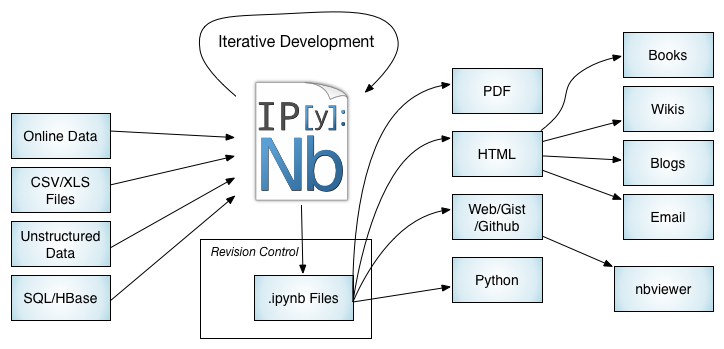

In [14]:
display.Image("https://www.opendatascience.com/wp-content/uploads/2015/12/IPython_Notebook_Workflows.png")

http://blog.fperez.org/2012/01/ipython-notebook-historical.html
https://groups.google.com/forum/#!topic/sage-devel/uc9HIMREh9Y

the natural flow of scientific computing pretty much mandates a solid interactive environment

cleaner parallel computing, multiprocess clients and a notebook. 
    
Because our notebook works in the normal filesystem, and lets you create .py files right 
next to the .ipynb just by passing --script at startup, you can reuse your notebooks like normal scripts, import one notebook from another or a normal python script, etc.


# Journalism segue